In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
os.chdir(r"D:\downloads")


In [3]:
df = pd.read_csv("tips.csv")

In [4]:
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [6]:
df.shape

(244, 7)

In [7]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [8]:
df.duplicated().sum()

np.int64(1)

In [9]:
df.drop_duplicates()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<Axes: xlabel='total_bill', ylabel='tip'>

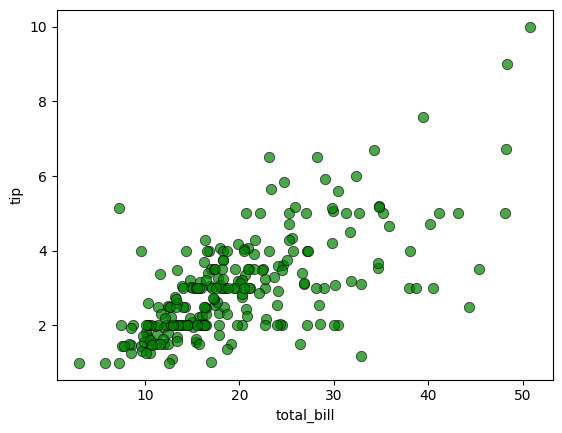

In [10]:
sns.scatterplot(x='total_bill', y='tip', data=df, color='green', alpha=0.7, edgecolor='k', s=55)


So from the scatter plot we find there exist a postive but moderate correlation between total bill and tip given.

In [11]:
df['total_bill'].corr(df['tip'])

np.float64(0.6757341092113645)

In [12]:
df_data = df.drop(columns=['tip'])

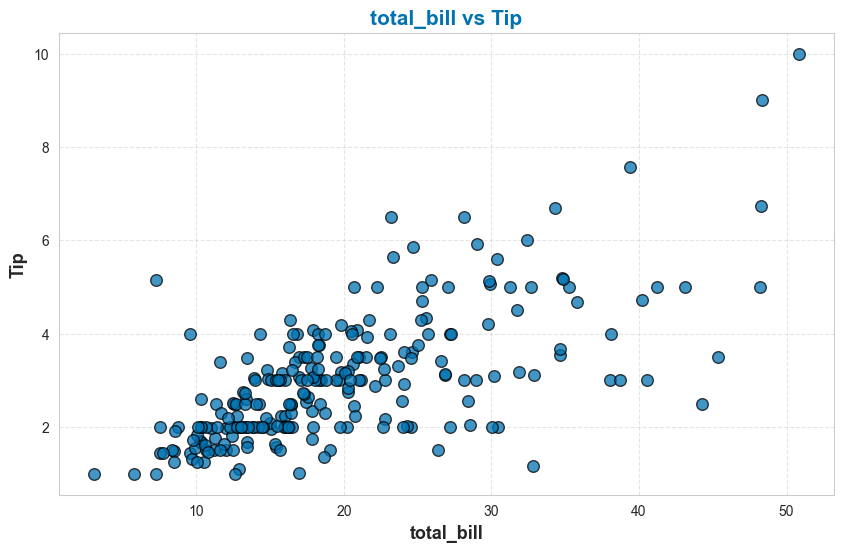

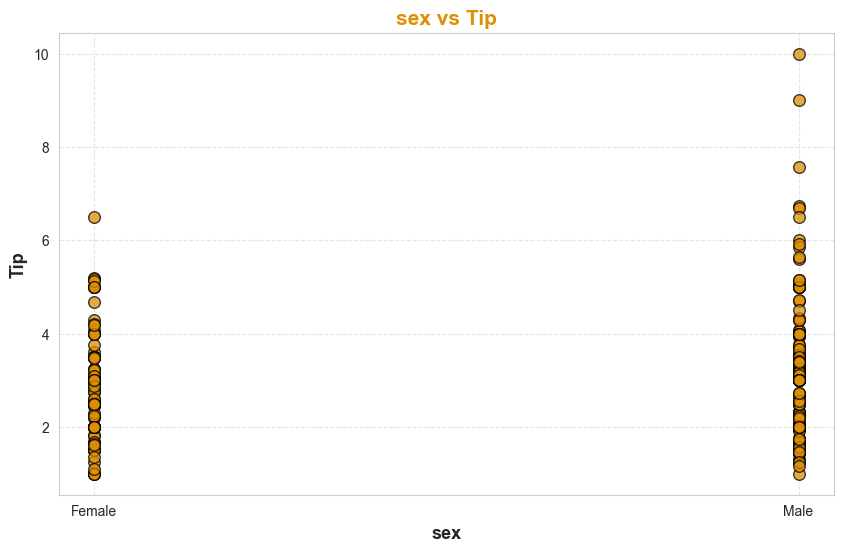

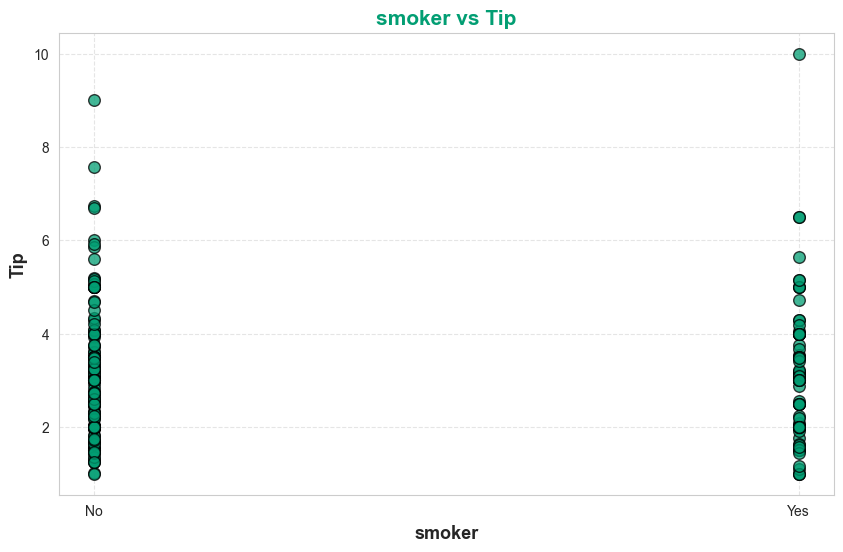

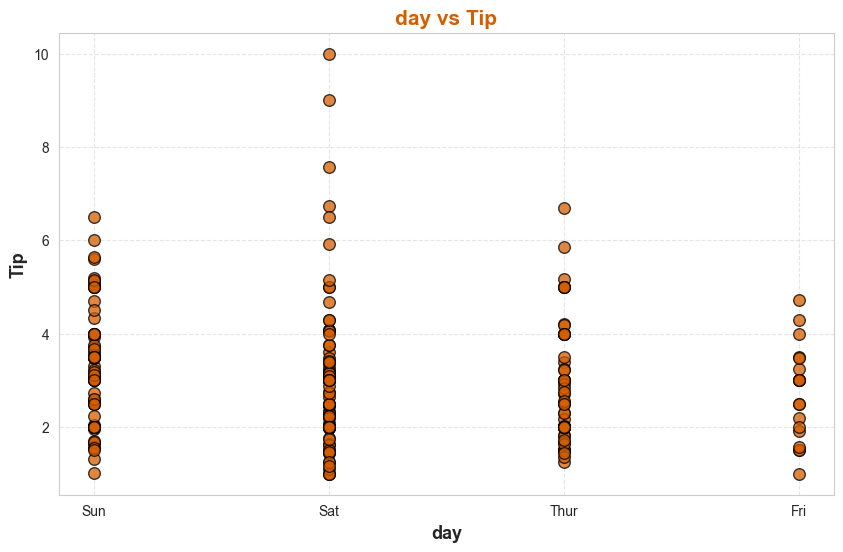

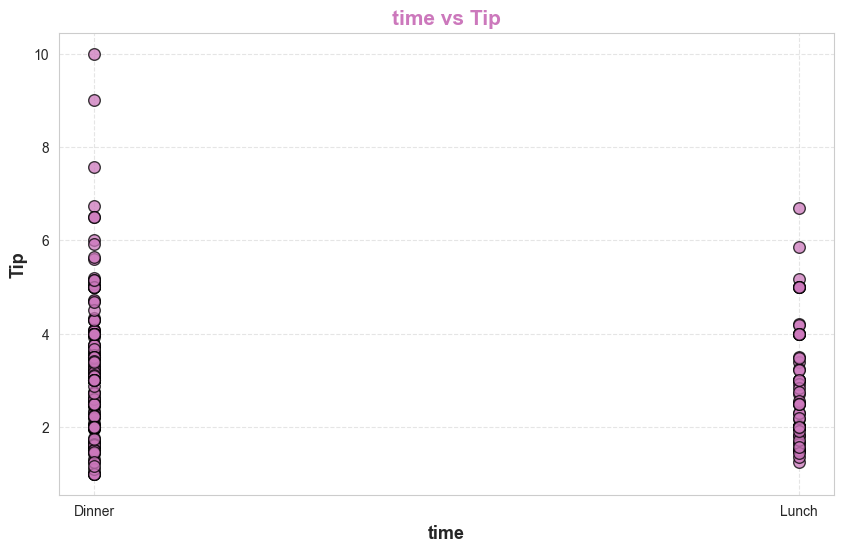

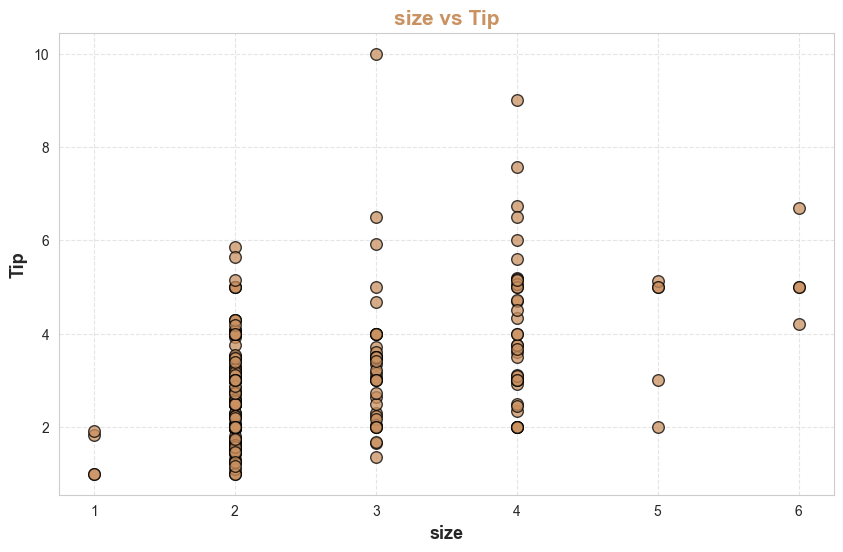

In [13]:
sns.set_style("whitegrid")
palette = sns.color_palette("colorblind", df_data.shape[1])

df_target = df['tip']
for i in range(df_data.shape[1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_data.iloc[:, i], df_target, color=palette[i], alpha=0.75, edgecolor='black', s=70)
    plt.xlabel(df_data.columns[i], fontsize=13, fontweight='bold')
    plt.ylabel('Tip', fontsize=13, fontweight='bold')
    plt.title(f"{df_data.columns[i]} vs Tip", fontsize=15, fontweight='bold', color=palette[i])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


So we found that 
1. Male customers tend to give higher tips than female customers.
2. Weekend have much higher customers with least on Friday
3. Smoking preferences don’t significantly affect tipping behavior
4. Tip amounts tend to be higher during dinner hours than at lunchtime.
5. Largerer groups of people typically lead to higher tip amounts

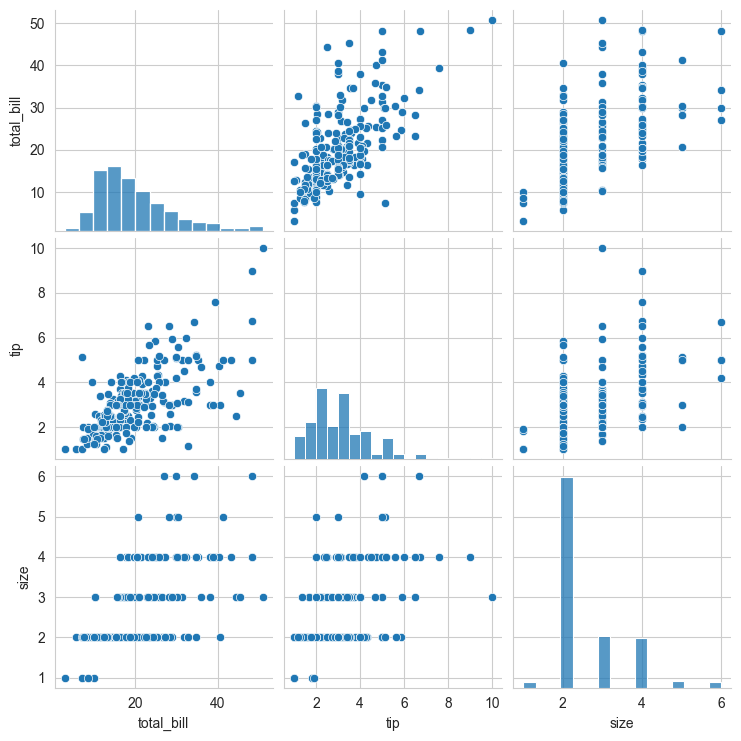

In [14]:
sns.pairplot(df)

<Axes: >

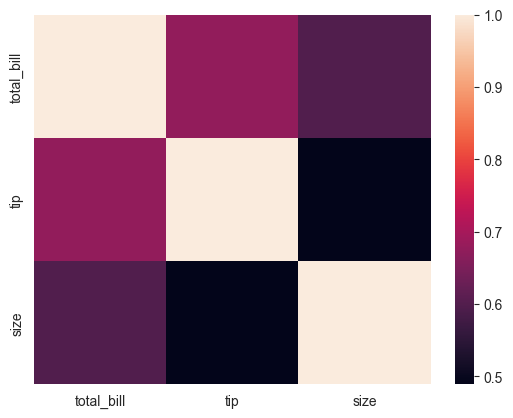

In [15]:
sns.heatmap(df[['total_bill', 'tip', 'size']].corr())

Now we will perform Rainbow test. Since Rainbow trst is appicable only on numerical data hecne we will first do label encoding

In [16]:
label_encoder = LabelEncoder()
df_data['sex'] = label_encoder.fit_transform(df['sex'])
df_data['smoker'] = label_encoder.fit_transform(df['smoker'])
df_data['day'] = label_encoder.fit_transform(df['day'])
df_data['time'] = label_encoder.fit_transform(df['time'])

In [17]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_rainbow

X = df_data
X = sm.add_constant(X)
y = df_target

model = sm.OLS(y, X).fit()

# Perform the Rainbow Test
rainbow_stat, rainbow_p_value = linear_rainbow(model)

print("Rainbow Test Statistic:", rainbow_stat)
print("Rainbow Test p-value:", rainbow_p_value)

if rainbow_p_value < 0.05:
    print("Significant non-linearity detected (p < 0.05). Consider using a non-linear model.")
else:
    print("No significant non-linearity detected (p >= 0.05). The linearity assumption holds.")


Rainbow Test Statistic: 1.2036274510126599
Rainbow Test p-value: 0.15798464222013184
No significant non-linearity detected (p >= 0.05). The linearity assumption holds.


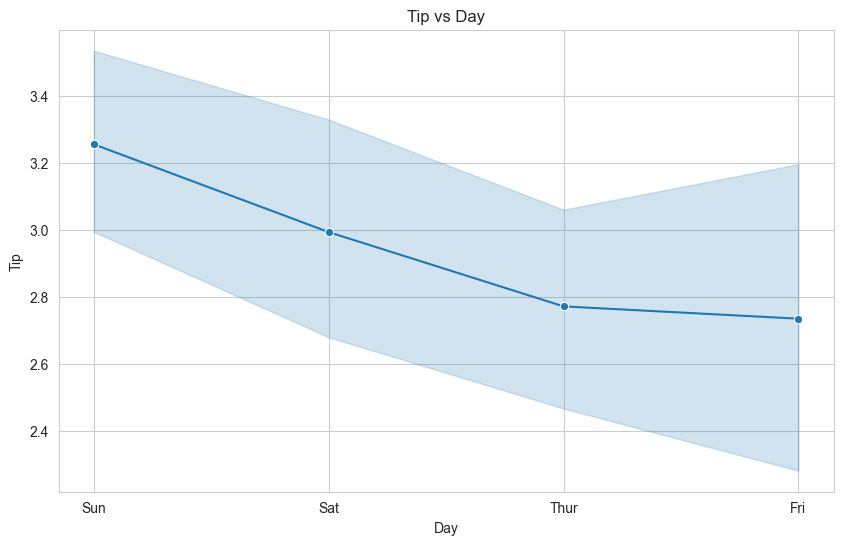

In [18]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='day', y='tip', marker='o')
plt.title('Tip vs Day')
plt.xlabel('Day')
plt.ylabel('Tip')
plt.show()

## Now we will train the model and check it's performance using Residual plots

In [19]:
##We are applying one-hot encoding to eliminate any potential ranking bias in the model, ensuring that categorical variables are treated as distinct, non-ordinal values.

tips_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'day', 'time'], drop_first=True)
X = tips_encoded.drop(columns='tip')
y = tips_encoded['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1. Linear Regression

In [20]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_lr = linear_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print("Linear Regression -\nMSE:", mse_lr, "\nR^2:", r2_lr, "\nRMSE:", np.sqrt(mse_lr))

Linear Regression -
MSE: 0.7033566017436105 
R^2: 0.43730181943482505 
RMSE: 0.838663580790063


## 2. Ridge and Lasso Regularixation

In [21]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge Regression -\nMSE:", mse_ridge, "\nR^2:", r2_ridge, "\nRMSE:", np.sqrt(mse_ridge))


lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("Lasso Regression -\nMSE:", mse_lasso, "\nR^2:", r2_lasso, "\nRMSE:", np.sqrt(mse_lasso))

Ridge Regression -
MSE: 0.7007477213216073 
R^2: 0.4393889716178486 
RMSE: 0.8371067562274285
Lasso Regression -
MSE: 0.5908528649971524 
R^2: 0.5273068720881755 
RMSE: 0.768669542129225


## 3. RandomForest

In [22]:
forest = RandomForestRegressor(random_state=42, n_estimators=100)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

# Evaluate model
mse_forest = mean_squared_error(y_test, y_pred_forest)
r2_forest = r2_score(y_test, y_pred_forest)
print("Random Forest -\nMSE:", mse_forest, "\nR^2:", r2_forest, "\nRMSE:", np.sqrt(mse_forest))

Random Forest -
MSE: 0.9196720148979602 
R^2: 0.2642455218065466 
RMSE: 0.9589953153680993


## 4. Decison Tree

In [23]:

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Evaluate model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)
print("Decision Tree -\nMSE:", mse_tree, "\nR^2:", r2_tree, "\nRMSE:", np.sqrt(mse_tree))

Decision Tree -
MSE: 1.2551938775510205 
R^2: -0.004178121600921791 
RMSE: 1.120354353564541


## 5. SVR

In [24]:
svr = SVR(kernel='linear')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# Evaluate model
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print("Support Vector Regression -\nMSE:", mse_svr, "\nR^2:", r2_svr, "\nRMSE:", np.sqrt(mse_svr))

Support Vector Regression -
MSE: 0.6524534436627769 
R^2: 0.47802527943520123 
RMSE: 0.8077459029068342


## 6. KNN

In [25]:

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Evaluate model
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
print("K-Nearest Neighbors -\nMSE:", mse_knn, "\nR^2:", r2_knn, "\nRMSE:", np.sqrt(mse_knn))

K-Nearest Neighbors -
MSE: 0.8763725714285714 
R^2: 0.29888587066985495 
RMSE: 0.9361477294896203


In [26]:
##For feature selection use Lasso 
feature_importance = pd.Series(lasso.coef_, index=X.columns)
significant_features = feature_importance[feature_importance != 0].sort_values(ascending=False)
print("Significant Factors impacting tips:")
print(significant_features)

Significant Factors impacting tips:
size          0.108081
total_bill    0.099099
dtype: float64


### Best Model from above = Lasso ( as Highest R2 and Lowest MSE)

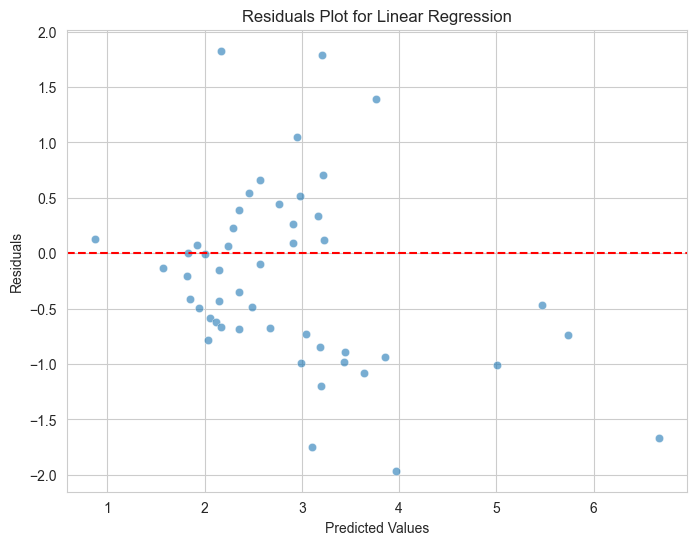

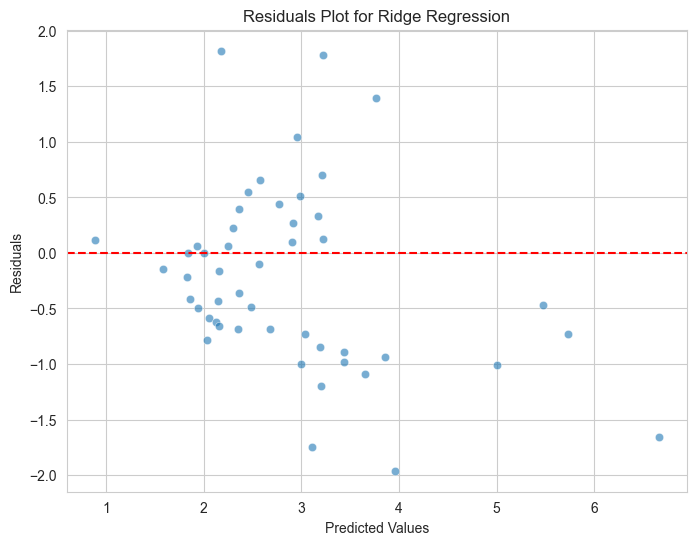

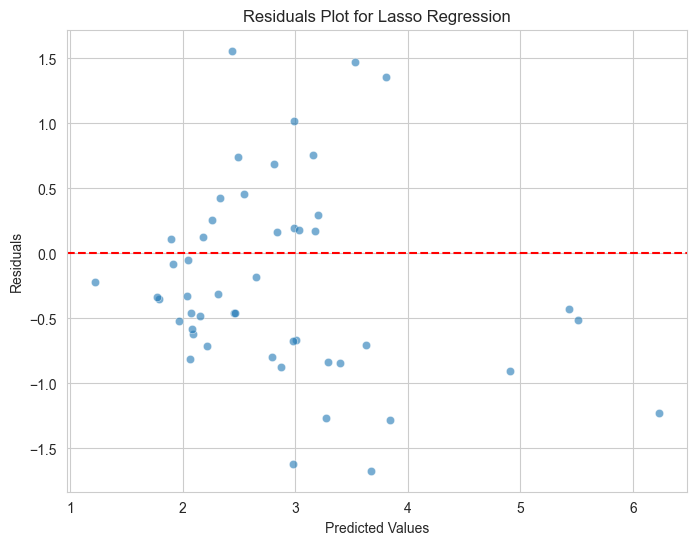

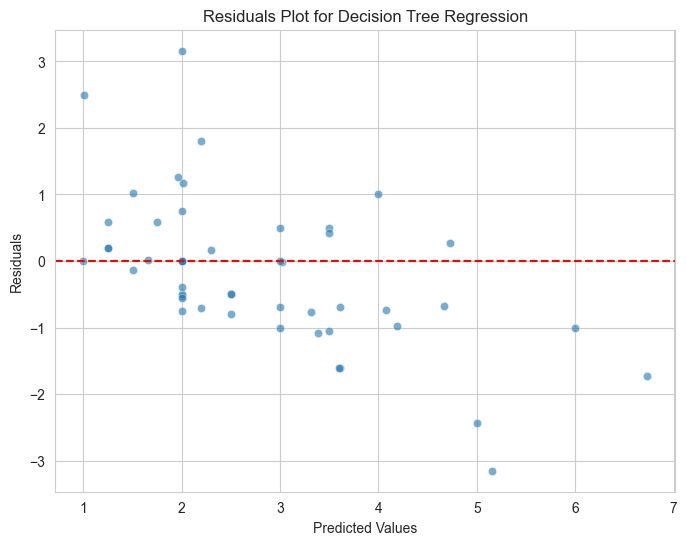

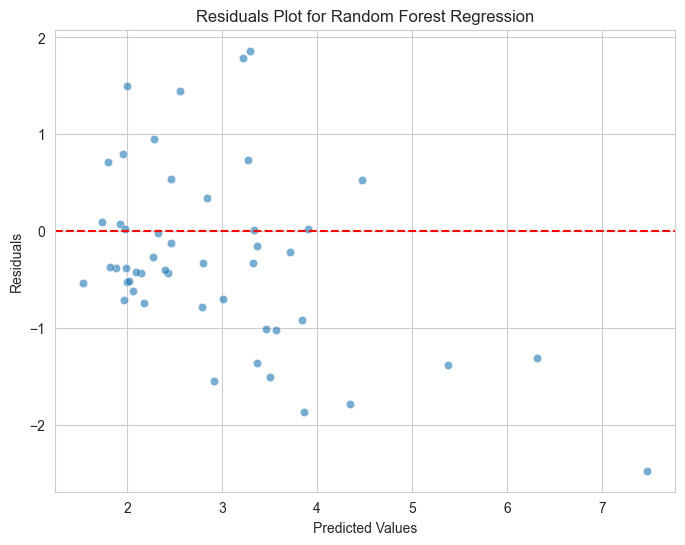

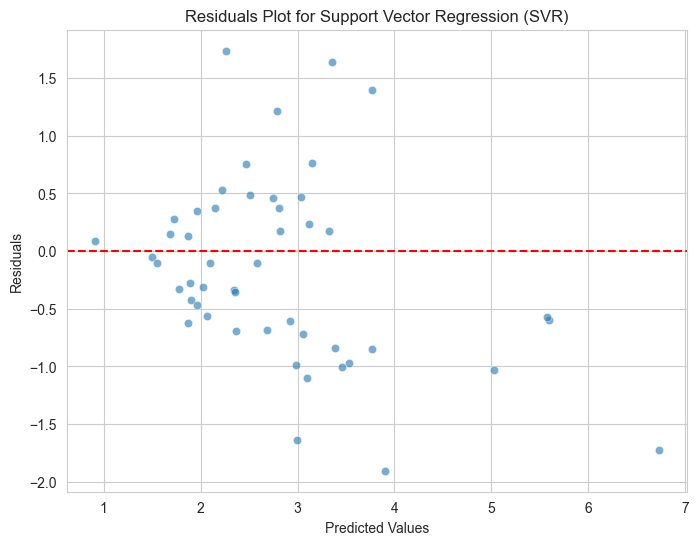

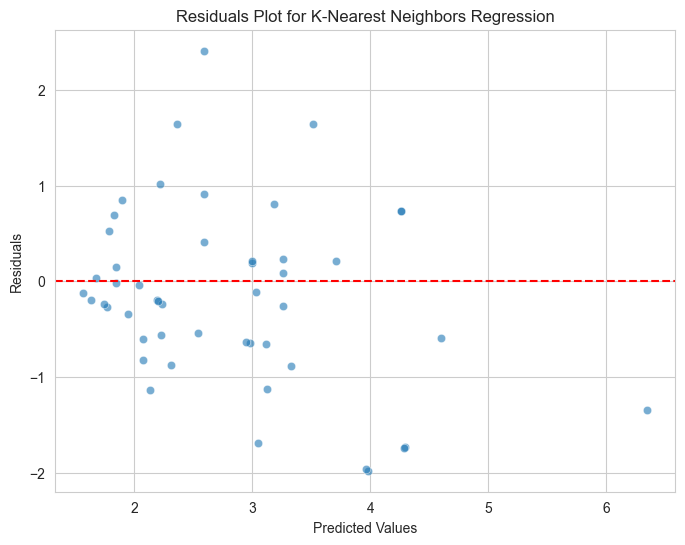

In [27]:
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals Plot for {model_name}")
    plt.show()
models = {
    "Linear Regression": linear_reg,
    "Ridge Regression": ridge,
    "Lasso Regression": lasso,
    "Decision Tree Regression": tree,
    "Random Forest Regression": forest,
    "Support Vector Regression (SVR)": svr,
    "K-Nearest Neighbors Regression": knn
}


for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_residuals(y_test, y_pred, model_name)


From the analysis above, we observe that the Decision Tree model exhibits the smallest residuals, which suggests that it may be overfitting the training data.

# Ways to increase tip

1. Offer promotions and better service on Fridays to increase customer visits.
2. Give priority to larger groups as they tend to tip more.
3. Improve food and service quality to boost customer satisfaction and tips.  
4. Focus on dinner time service for higher tip collection.

